***Note: This example is discussed in detail by 
    <cite data-cite="GawPan20X">(Gawthrop and Pan, 2020)</cite> 
    available [here](https://arxiv.org/abs/2009.02217).***

***Note: this is the SGLT.ipynb notebook. The
PDF version "Sodium Glucose Symporter"
is available [here](SGLT.pdf).***


# Introduction
The Sodium-Glucose Transport Protein 1 (SGLT1) (also known as the
\ch{Na+}-glucose symporter \citep[\S~2.4.2]{KeeSne09}) was studied experimentally by
\citet{ParSupLoo92} and explained by a biophysical model
\citep{ParSupLoo92a}; further experiments and modelling were conducted
by \citet{CheCoaJac95}.  \citet{EskWriLoo05} examined the kinetics of
the reverse mode using similar experiments and analysis to
\citet{ParSupLoo92,ParSupLoo92a} but with reverse transport and
currents.

This note looks at a bond graph based model
of SGLT1 based on the model of \citet{EskWriLoo05}.

The model of Figure 6B of
 \citet{EskWriLoo05} is based on the six-state
biomolecular cycle of Figure 2 of \citet{ParSupLoo92a}. When operating
normally, sugar is transported from the outside to the inside of the
membrane driven against a possibly adverse gradient by the
concentration gradient of \ch{Na+}. 

A similar situation is analysed in \S~1.1 of the book by \citet{Hil89}
and the corresponding bond graph of the biomolecular cycle is
described by \citet{GawCra17}.

In [1]:
## Some useful imports
import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

## Stoichiometric analysis
import stoich as st

## SVG
import svgBondGraph as sbg

## Display (eg disp.SVG(), disp.
import IPython.display as disp

quiet = True

## Data file
import json

## Save the figure
SaveFig = False

TranslateSVG = False

In [2]:
## Load data from Eskandari et. al. Fig 3A
## Digitised using  https://apps.automeris.io/wpd/

def loadData():
    
    with open('SGLT_data.json') as f:
        Dict = json.load(f)
        
    List = Dict['datasetColl'][0]['data']

    X = []
    Y = []
    for item in List:
        xy = item['value']
        X.append(xy[0])
        Y.append(xy[1])

    return X,Y

print(loadData())

([-149.08132530120483, -128.50492880613362, -108.26396495071195, -88.92935377875138, -68.92045454545456, -49.776150054764514, -29.841182913472096, -9.930859802847777, 11.341730558597988, 30.71741511500545], [1.3909090909090907, 1.8090909090909086, 3.409090909090909, 3.6636363636363636, 4.236363636363636, 4.9818181818181815, 5.2272727272727275, 5.363636363636363, 4.863636363636363, 5.3])


# Sodium-Glucose Symporter - zero membrane potential.
This non-electrogenic version is used to compute species and reaction parameters from the 
published model values.

## Bond graph

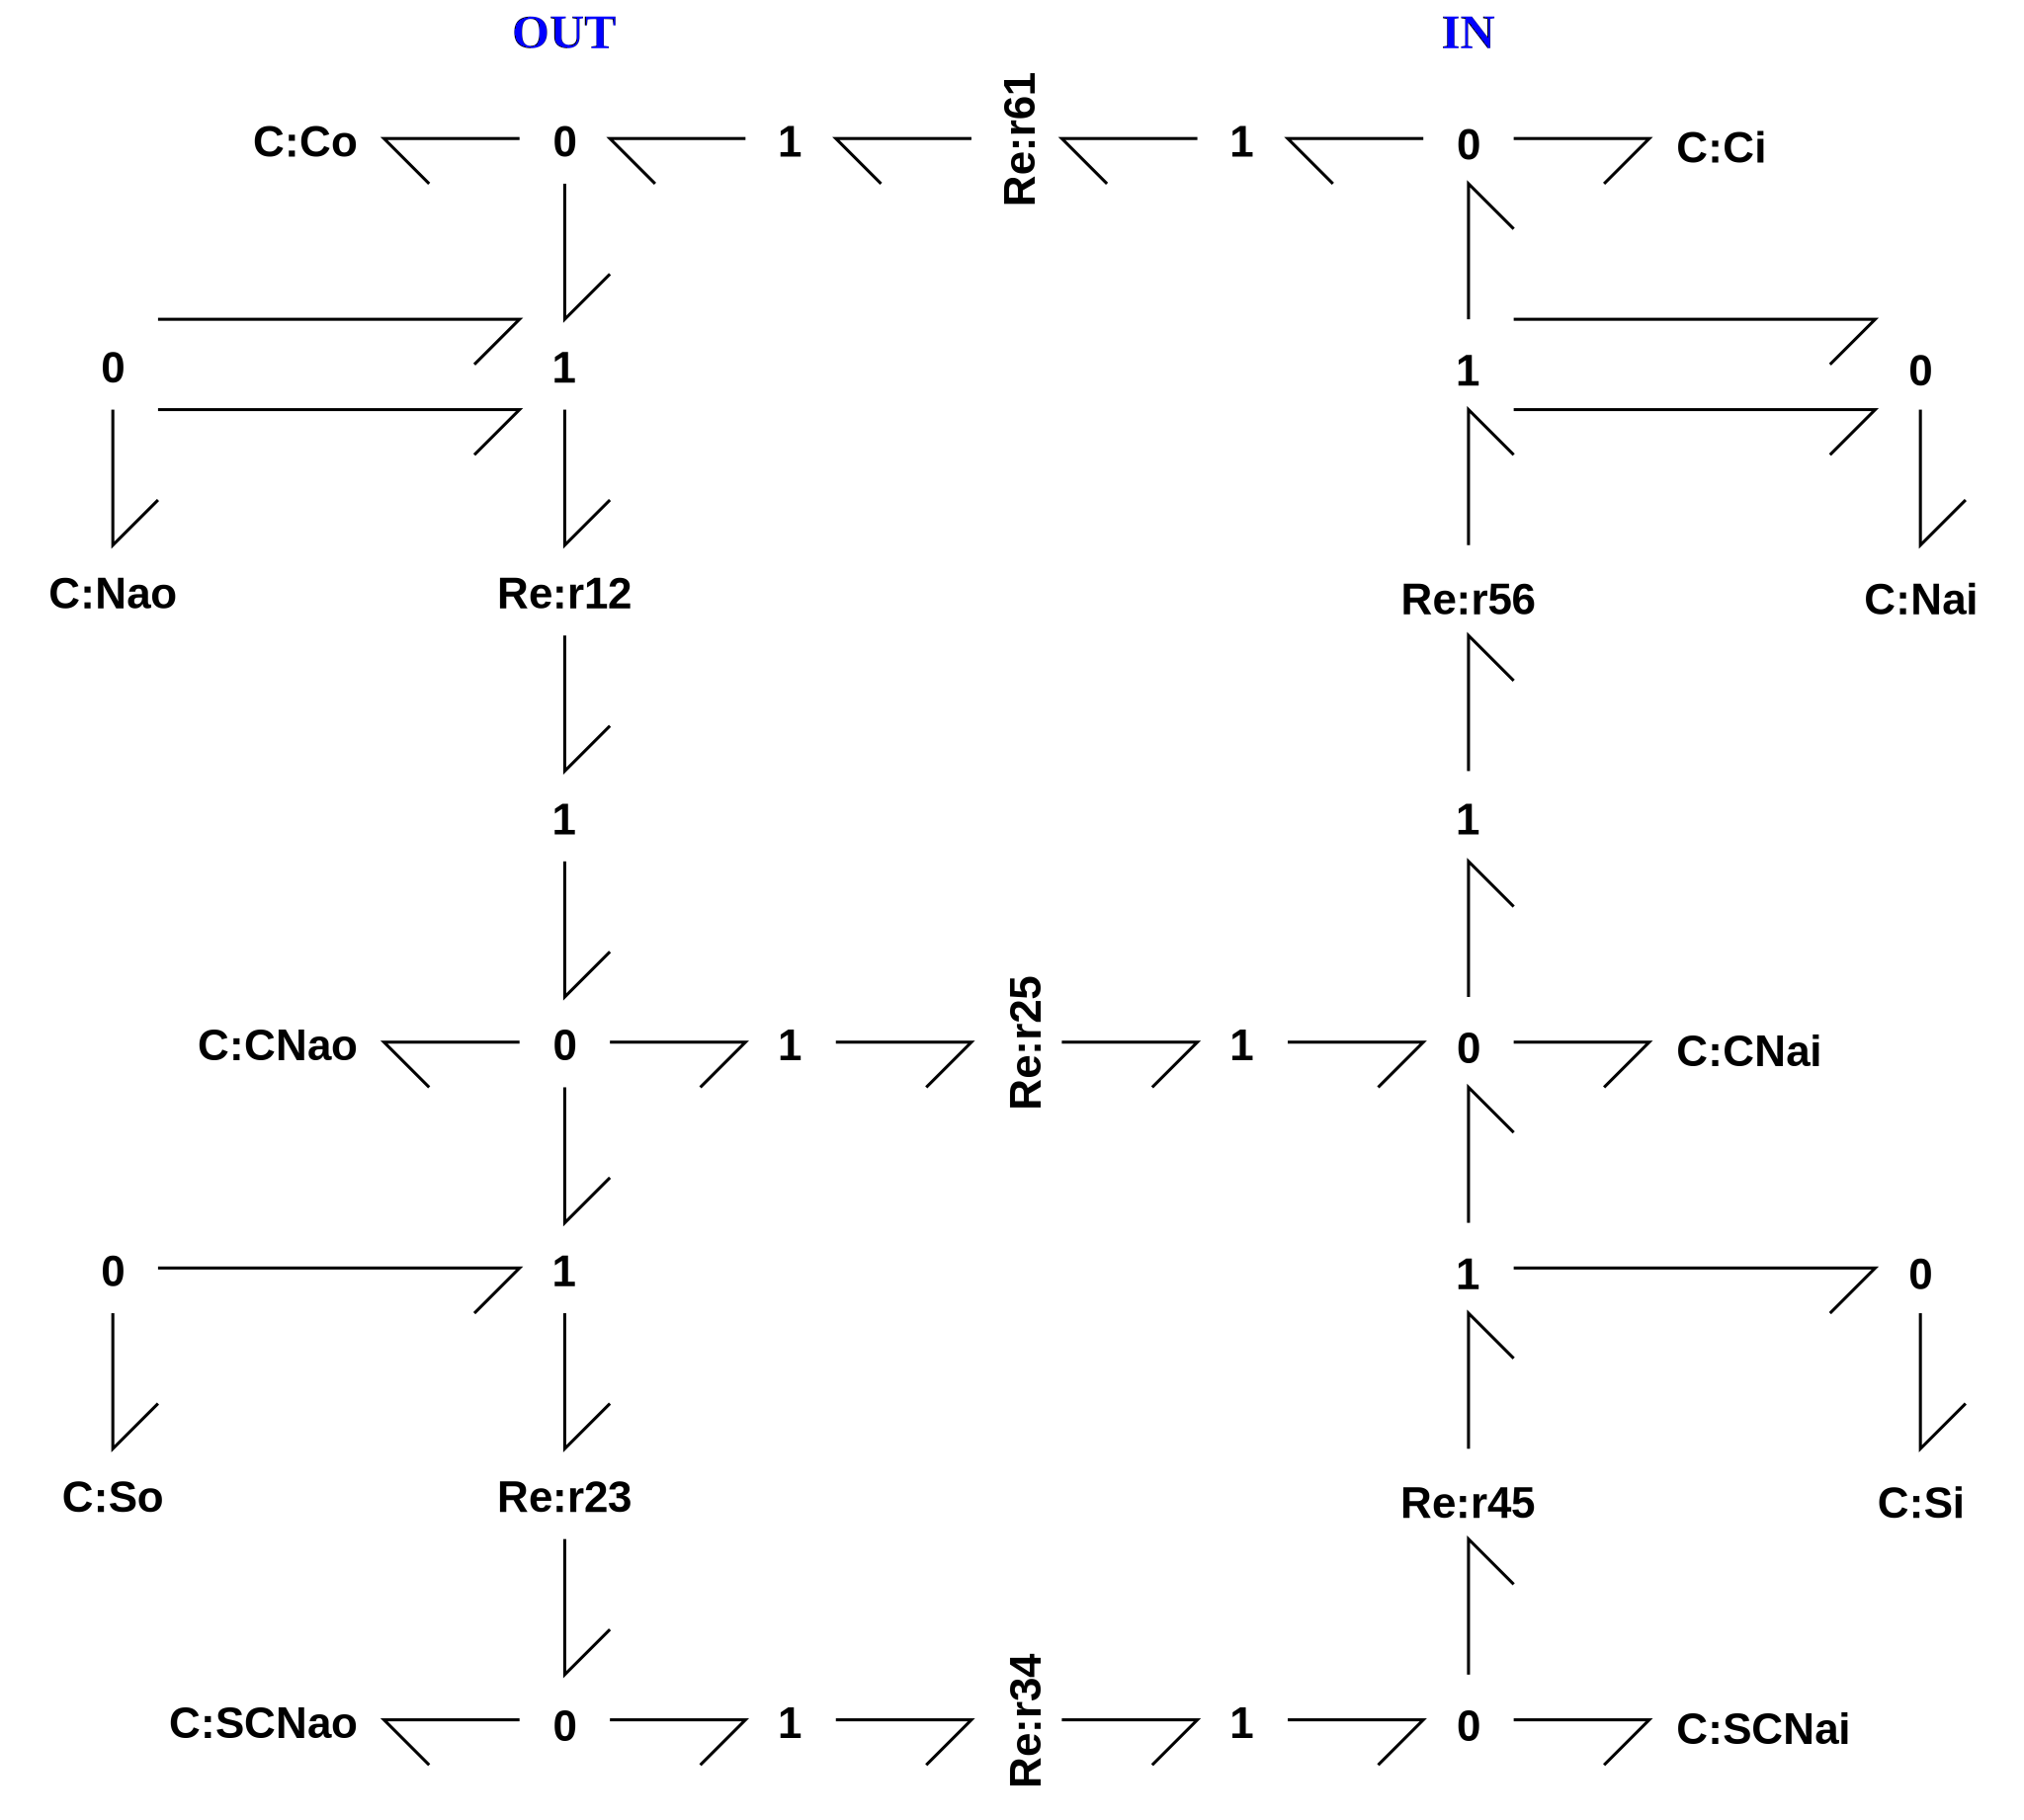

In [3]:
## Sodium-Glucose tranporter - no E
if TranslateSVG:
    sbg.model('SGLT_abg.svg')
import SGLT_abg
disp.SVG('SGLT_abg.svg')

## Stoichiometry

In [4]:
## Stoichiometry
s0 = st.stoich(SGLT_abg.model(),quiet=quiet)
chemostats = ['Nai','Nao','Si','So']
sc0 = st.statify(s0,chemostats=chemostats)
#print(s['species'])
#disp.Latex(st.sprint(s0,'K'))
#print(st.sprints(s))

## Convert parameters
The model of \citet{EskWriLoo05} is based on rate constants. The following code converts this into the parameters required for the bond graph model.

In [5]:
def Keq2K(K_eq,N,K,tol=1e-6):
    ## Compute BG C parameters K_c from equilibrium constants K_eq.
    ## NB K_eq must be thremodynamically consistent.
    
    logK_eq = np.log(K_eq)
    #print(K_eq)
    #print(logK_eq)
    
    if len(K) != 0:
        ##First check that Keq is thermodynamically consistent.
        check = np.linalg.norm(K.T*logK_eq)/np.linalg.norm(logK_eq)
        print(check)
    
    ## Transformation of mu to affinities
    NN = -N.T
    
    ## Pseudo inverse
    pNN = np.linalg.pinv(NN)
    
    ## BG C constants
    K_c = np.exp(pNN@logK_eq)
    
    return K_c

In [6]:
## Set non-unit parameters using data from EskWriLoo05
def setPar(s,tol=1e-6):
    
    ## Extract stoichiometry
    N = s['N']
    Nf = s['Nf']
    Nr = s['Nr']
    K = s['K']
    
    n_V = s['n_V']
    
    
    ## Rate constants from Fig 6.
    kf = {}
    kr = {}
    
    ## Rate constants from Fig 6.
    kf['r12'] = 8e4;
    kr['r12'] = 500;

    kf['r23'] = 1e5;
    kr['r23'] = 20;

    kf['r34'] = 50;
    kr['r34'] = 50;

    kf['r45'] = 800;
    kr['r45'] = 12190;

    kf['r56'] = 10;
    kr['r56'] = 4500;

    kf['r61'] = 3;
    kr['r61'] = 350;

    kf['r25'] = 0.3;
    kr['r25'] = 9.1e-4;

    ## Equilibrium constants.
    K_eq = np.zeros(n_V)
    k_f = np.zeros(n_V)
    k_r = np.zeros(n_V)
    for i,reac in enumerate(s['reaction']):
        K_eq[i] = kf[reac]/kr[reac]
        k_f[i] = kf[reac]
        k_r[i] = kr[reac]
    
    ## Compute Ce constants from equilibrium constants
    K_c = Keq2K(K_eq,N,K)
    
#     print(K_eq)
#     print(s['n_X'], K_c.shape)
        
    # Forward rates induced by Cs
    k_f0 = np.exp(Nf.T@np.log(K_c))
    
    ## Rate constants kappa (Amps)
    kappa = (k_f/k_f0)*st.F()
    
    ## Sanity check
    k_r0 = np.exp(Nr.T@np.log(K_c))
    kappa_r = (k_r/k_r0)*st.F()
    check = np.linalg.norm(kappa-kappa_r)
    
    if check>tol:
        print(f'Error in kappa: {check:.2}')
    
    
    ## Parameters
    parameter = {}
    
    ## Ce constants
    for i,spec in enumerate(s['species']):
        print(f'K_{spec} = {K_c[i]:.4}')
        parameter['K_'+spec] = K_c[i]
        
    ## Re constants
    for i,reac in enumerate(s['reaction']):
        print(f'{reac} K_eq = {K_eq[i]:.4f}; kappa = {kappa[i]:.4f}')
        parameter['kappa_'+reac] = kappa[i]
      
    return parameter

par = setPar(s0)
#print(par)

Error in kappa: 1.2e-05
K_CNai = 0.149
K_CNao = 49.12
K_Ci = 0.3457
K_Co = 40.33
K_Nai = 13.93
K_Nao = 13.96
K_SCNai = 0.099
K_SCNao = 0.099
K_Si = 10.12
K_So = 10.08
r12 K_eq = 160.0000; kappa = 982183.7246
r23 K_eq = 5000.0000; kappa = 19492291.8173
r25 K_eq = 329.6703; kappa = 589.3102
r34 K_eq = 1.0000; kappa = 48730729.5432
r45 K_eq = 0.0656; kappa = 779691672.6910
r56 K_eq = 0.0022; kappa = 6475936.6454
r61 K_eq = 0.0086; kappa = 837303.6199


# Electrogenic Sodium-Glucose Symporter


## Bond graph
The component C:E is added to express the effect of the charged \ch{Na+} ion crossing the membrane.

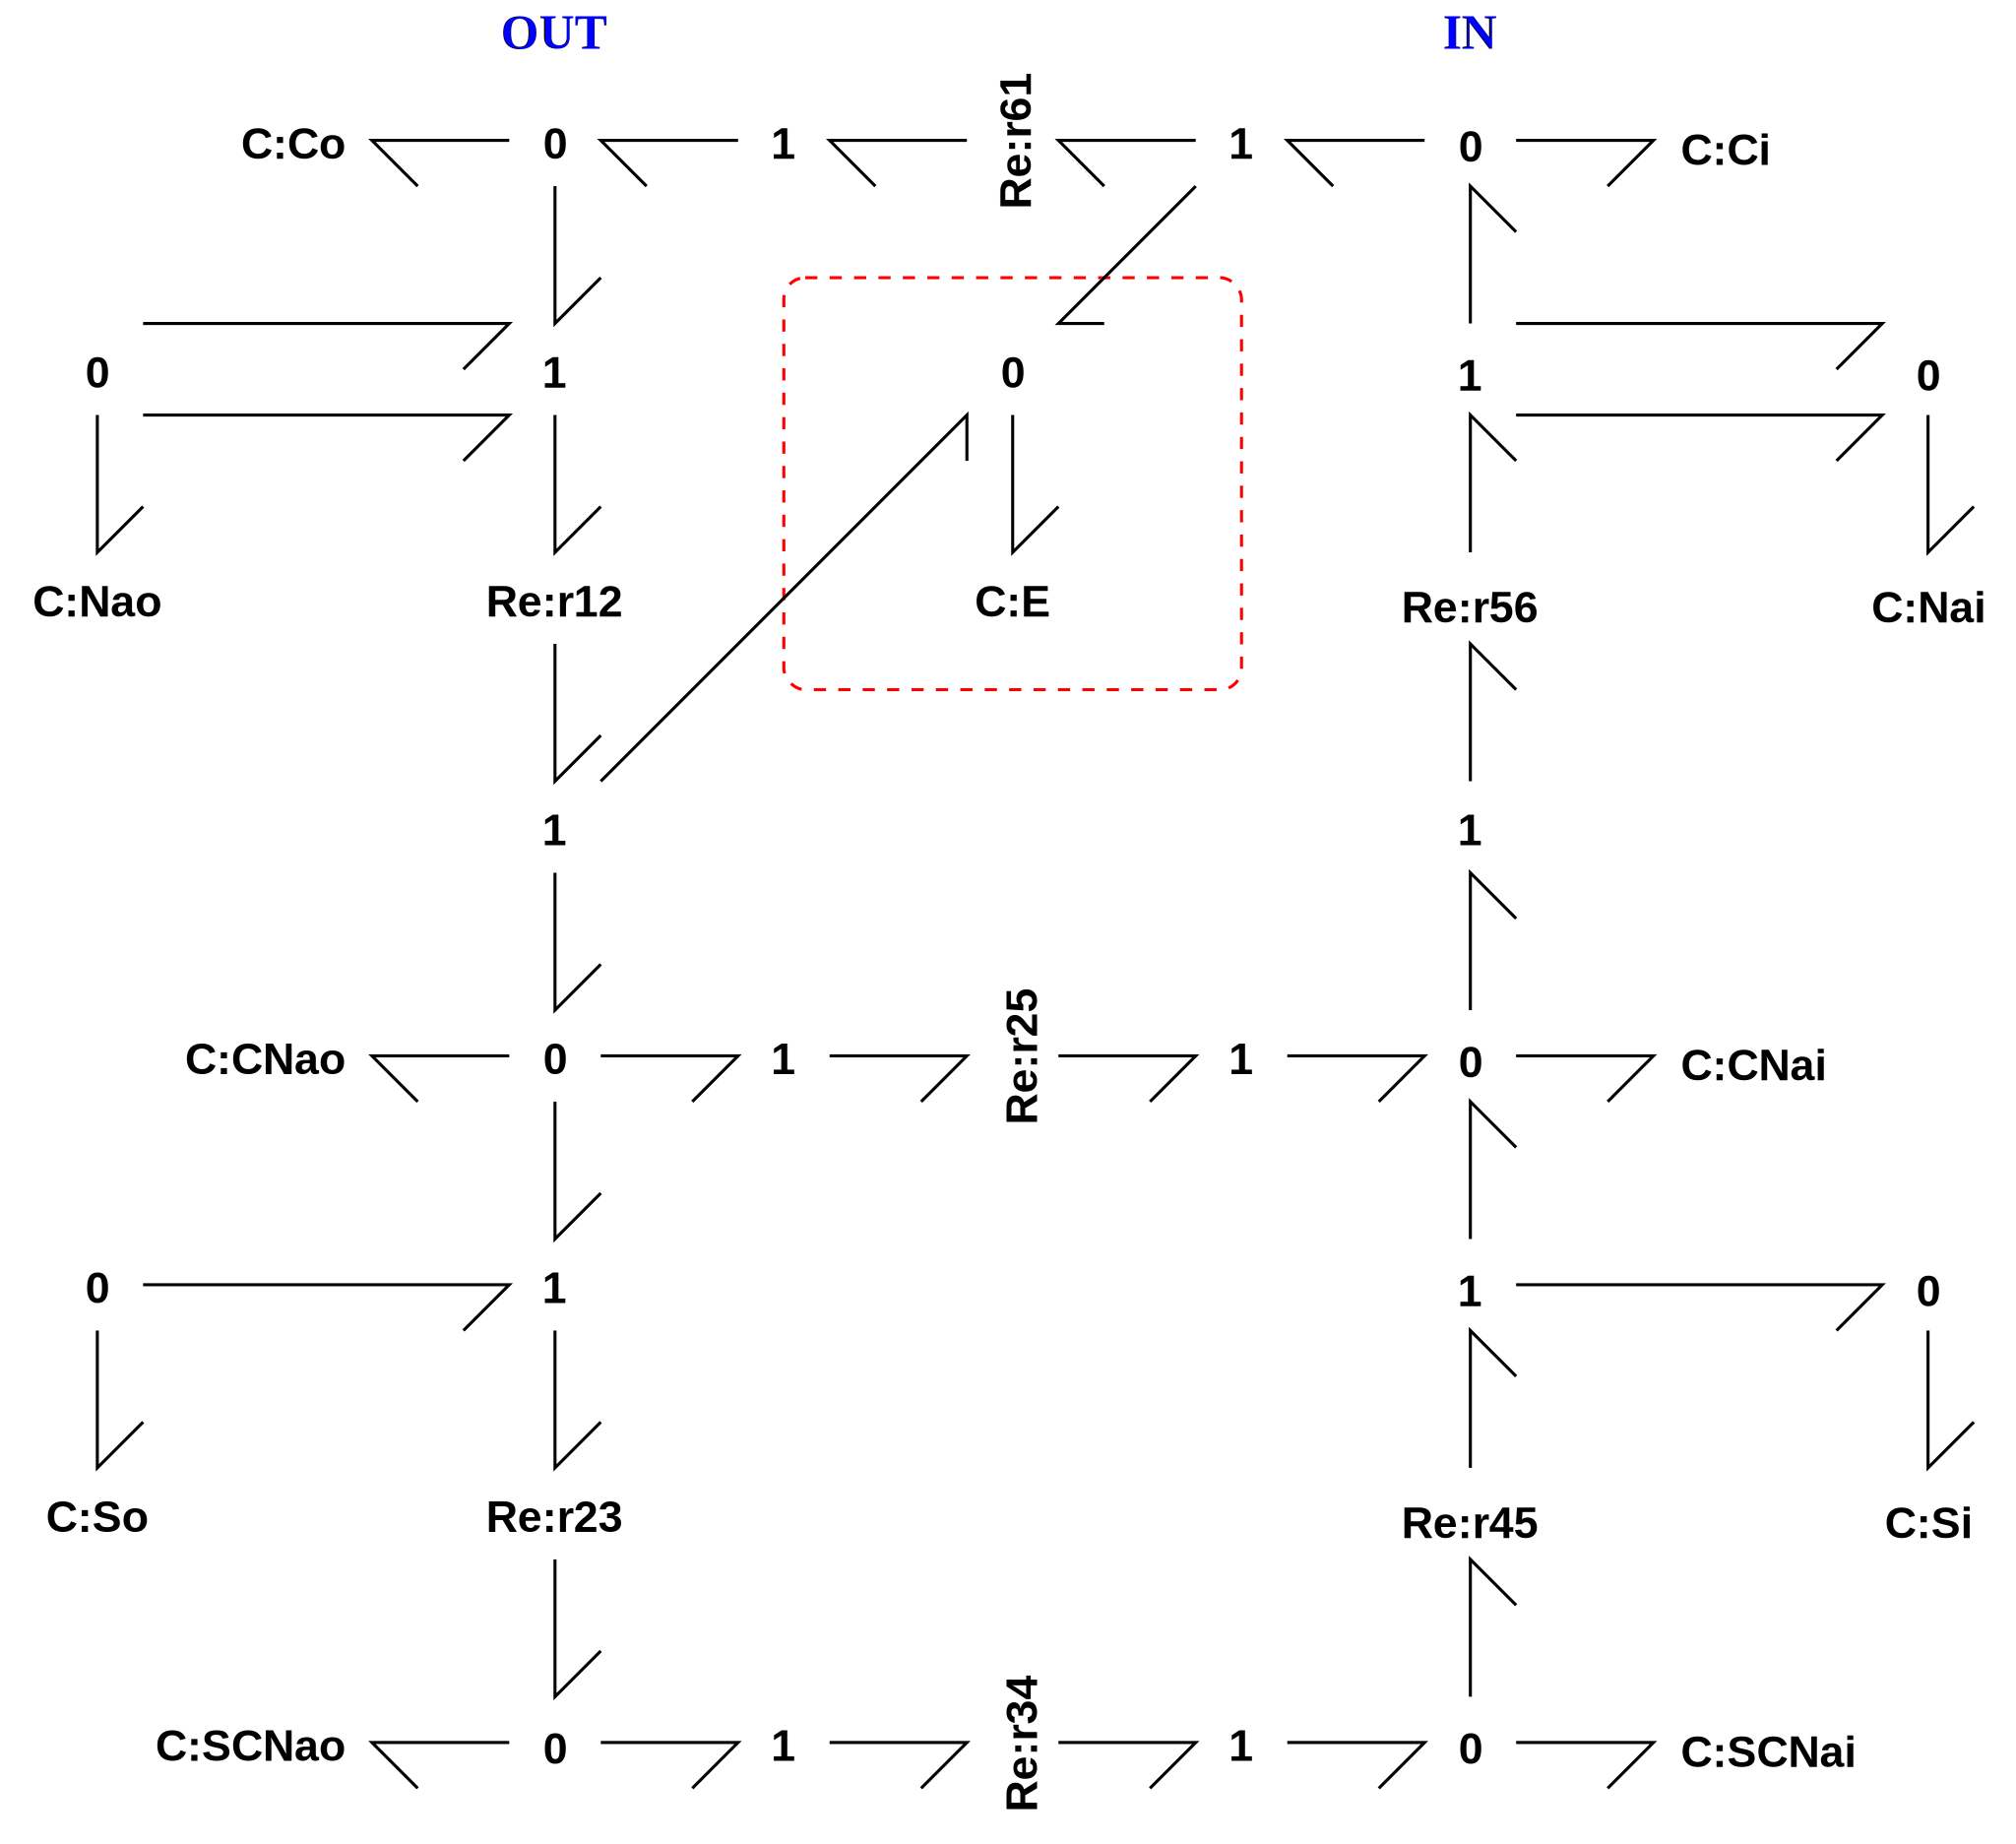

In [7]:
## Sodium-Glucose tranporter - electrogenic
if TranslateSVG:
    sbg.model('ESGLT_abg.svg')
import ESGLT_abg
disp.SVG('ESGLT_abg.svg')

## Stoichiometry

In [8]:
## Stoichiometry
s = st.stoich(ESGLT_abg.model(),linear=['E'], quiet=quiet)
chemostats = ['Nai','Nao','Si','So','E']
sc = st.statify(s,chemostats=chemostats)

disp.Latex(st.sprint(sc,'K'))

K:
 [[ 0  1]
 [ 1  0]
 [-1  1]
 [ 1  0]
 [ 1  0]
 [ 0  1]
 [ 0  1]]


<IPython.core.display.Latex object>

## Reactions and flows

In [9]:
## Reactions
disp.Latex(st.sprintrl(s,chemformula=True,all=True))

<IPython.core.display.Latex object>

In [10]:
## Flows
disp.Latex(st.sprintvl(s))

<IPython.core.display.Latex object>

## Sdet up initial conditions for simulation

In [11]:
def setX(s):
    
    sp = s['species']
    X0 = np.zeros(s['n_X'])
    X0[sp.index('So')] = 1e-6
    X0[sp.index('Si')] = 1e-3
    X0[sp.index('Nao')] = 1e-2
    X0[sp.index('Nai')] = 0.5
    
#     X0 *= st.F()
    
    ## Normalised value
    C_T = 1
    others = ['Co','CNao','SCNao','Ci','CNai','SCNai']
    for spec in others:
        X0[sp.index(spec)] = C_T/len(others)
        
    #N_C = 3e6
    N_C = 7.5e7
    N_avo = 6.022e23
    C_T_0 = N_C/N_avo
    
    I_0_pA = 1e12*C_T_0/C_T
    
    print(f'N_C = {N_C}; i_0 = {I_0_pA}pA')
    
    #X0 *= st.F()
        
    return X0,I_0_pA

#print(setX(s))

# Comparison with experimental data

Error in kappa: 1.2e-05
K_CNai = 0.149
K_CNao = 49.12
K_Ci = 0.3457
K_Co = 40.33
K_Nai = 13.93
K_Nao = 13.96
K_SCNai = 0.099
K_SCNao = 0.099
K_Si = 10.12
K_So = 10.08
r12 K_eq = 160.0000; kappa = 982183.7246
r23 K_eq = 5000.0000; kappa = 19492291.8173
r25 K_eq = 329.6703; kappa = 589.3102
r34 K_eq = 1.0000; kappa = 48730729.5432
r45 K_eq = 0.0656; kappa = 779691672.6910
r56 K_eq = 0.0022; kappa = 6475936.6454
r61 K_eq = 0.0086; kappa = 837303.6199
N_C = 75000000.0; i_0 = 0.00012454334108269677pA
-0.17
-0.17 + 0.00022000000000000003*t
-0.17 0.05000000000000002


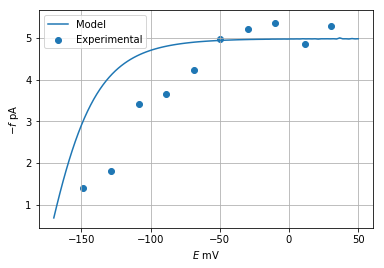

In [12]:
## Vary E
E0 = -170/1000
E1 = 50/1000
#E1 = 200/1000
X_chemo = {'E':str(E0)}

## Simulation
t = np.linspace(0,1e3,100)
parameter = setPar(s0)
X0,I_0_pA = setX(s)
dat = st.sim(s,sc=sc,t=t,parameter=parameter,X_chemo=X_chemo,X0=X0)

## Extract data
spec = s['species']
reac = s['reaction']
X_ss = dat['X'][-1,:]
print(X_ss[spec.index('E')])


x_E = f'{E0} + {(E1-E0)/max(t)}*t'
print(x_E)
X_chemo = {'E':x_E}

dat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X_ss,X_chemo=X_chemo)
f_E = dat['dX'][:,spec.index('E')]
E = dat['X'][:,spec.index('E')]

print(E[0],E[-1])

X,Y = loadData()
plt.plot(1000*E,-f_E*I_0_pA, label='Model')
plt.scatter(X,Y,label='Experimental')
plt.legend()
plt.grid()
plt.xlabel('$E$ mV')
plt.ylabel('$-f$ pA')
if SaveFig:
    plt.savefig('Figs/sglt.pdf')
plt.show()